<a href="https://colab.research.google.com/github/NehaTadavi/FODIP-Lab-Assignments/blob/main/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from collections import Counter
import heapq
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from google.colab import files
import pandas as pd


In [ ]:
print("Upload ZIP file containing dataset...")
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

Upload ZIP file containing dataset...


Saving Raccoon.v38-416x416-resize.ultralytics.zip to Raccoon.v38-416x416-resize.ultralytics.zip


In [ ]:
extract_folder = "train"
with ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
print(f"Extracted images to folder: {extract_folder}")

Extracted images to folder: train


In [ ]:
image_files = []
for root, dirs, files in os.walk(extract_folder):
    for f in files:
        if f.lower().endswith(('.jpg','.jpeg','.png')):
            image_files.append(os.path.join(root, f))
if len(image_files) == 0:
    raise ValueError("No images found in dataset.")
print(f"Found {len(image_files)} images.")


Found 392 images.


In [ ]:
class Node:
    def __init__(self, val, freq):
        self.val = val
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq


In [ ]:
def build_huffman_tree(symbols):
    heap = [Node(val,freq) for val,freq in symbols.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = Node(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

In [ ]:
def build_huffman_code(node, prefix="", code={}):
    if node is None:
        return
    if node.val is not None:
        code[node.val] = prefix
    build_huffman_code(node.left, prefix+"0", code)
    build_huffman_code(node.right, prefix+"1", code)
    return code

In [ ]:
def zigzag_scan(block):
    idx_order = sorted(((x,y) for x in range(8) for y in range(8)), key=lambda s: s[0]+s[1])
    return np.array([block[i,j] for i,j in idx_order])

def inverse_zigzag(vec):
    block = np.zeros((8,8))
    idx_order = sorted(((x,y) for x in range(8) for y in range(8)), key=lambda s: s[0]+s[1])
    for (i,j), val in zip(idx_order, vec):
        block[i,j] = val
    return block

In [ ]:
def rle_encode(arr):
    encoded = []
    prev = arr[0]
    count = 1
    for a in arr[1:]:
        if a == prev:
            count += 1
        else:
            encoded.append((prev, count))
            prev = a
            count = 1
    encoded.append((prev, count))
    return encoded

def rle_decode(rle):
    out = []
    for val,count in rle:
        out.extend([val]*count)
    return np.array(out)

In [ ]:
def dct2(block):
    return cv2.dct(block.astype(np.float32))

def idct2(block):
    return cv2.idct(block.astype(np.float32))

In [ ]:
Q50 = np.array([
[16,11,10,16,24,40,51,61],
[12,12,14,19,26,58,60,55],
[14,13,16,24,40,57,69,56],
[14,17,22,29,51,87,80,62],
[18,22,37,56,68,109,103,77],
[24,35,55,64,81,104,113,92],
[49,64,78,87,103,121,120,101],
[72,92,95,98,112,100,103,99]
])

def scale_quant_matrix(Q, quality):
    if quality < 50:
        S = 5000/quality
    else:
        S = 200 - 2*quality
    Q_scaled = np.floor((Q*S + 50)/100)
    Q_scaled[Q_scaled==0] = 1
    return Q_scaled

In [ ]:
def compress_channel(channel, Q):
    def build_huffman_tree(symbols):
        heap = [Node(val,freq) for val,freq in symbols.items()]
        heapq.heapify(heap)
        while len(heap) > 1:
            node1 = heapq.heappop(heap)
            node2 = heapq.heappop(heap)
            merged = Node(None, node1.freq + node2.freq)
            merged.left = node1
            merged.right = node2
            heapq.heappush(heap, merged)
        return heap[0]

    def build_huffman_code(node, prefix="", code={}):
        if node is None:
            return
        if node.val is not None:
            code[node.val] = prefix
        build_huffman_code(node.left, prefix+"0", code)
        build_huffman_code(node.right, prefix+"1", code)
        return code

    h, w = channel.shape
    padded_h = ((h-1)//8 + 1)*8
    padded_w = ((w-1)//8 + 1)*8
    padded = np.zeros((padded_h, padded_w))
    padded[:h,:w] = channel
    padded -= 128
    quant = scale_quant_matrix(Q50, Q)
    blocks = []
    for i in range(0,padded_h,8):
        for j in range(0,padded_w,8):
            block = padded[i:i+8,j:j+8]
            dct_block = dct2(block)
            q_block = np.round(dct_block/quant)
            zz = zigzag_scan(q_block)
            rle = rle_encode(zz)
            blocks.append(rle)
    # Huffman code
    all_symbols = [sym for block in blocks for sym in block]
    freq_table = Counter(all_symbols)
    huff_tree = build_huffman_tree(freq_table)
    huff_code = build_huffman_code(huff_tree)
    bitstream = "".join([huff_code[sym] for sym in all_symbols])
    return blocks, quant, huff_code, bitstream, padded_h, padded_w

def decompress_channel(blocks, quant, padded_h, padded_w, h, w):
    channel_rec = np.zeros((padded_h, padded_w))
    idx = 0
    for i in range(0,padded_h,8):
        for j in range(0,padded_w,8):
            rle = blocks[idx]
            idx += 1
            zz = rle_decode(rle)
            q_block = inverse_zigzag(zz)
            dequant = q_block*quant
            idct_block = idct2(dequant)
            channel_rec[i:i+8,j:j+8] = idct_block
    channel_rec += 128
    return np.clip(channel_rec[:h,:w], 0, 255)

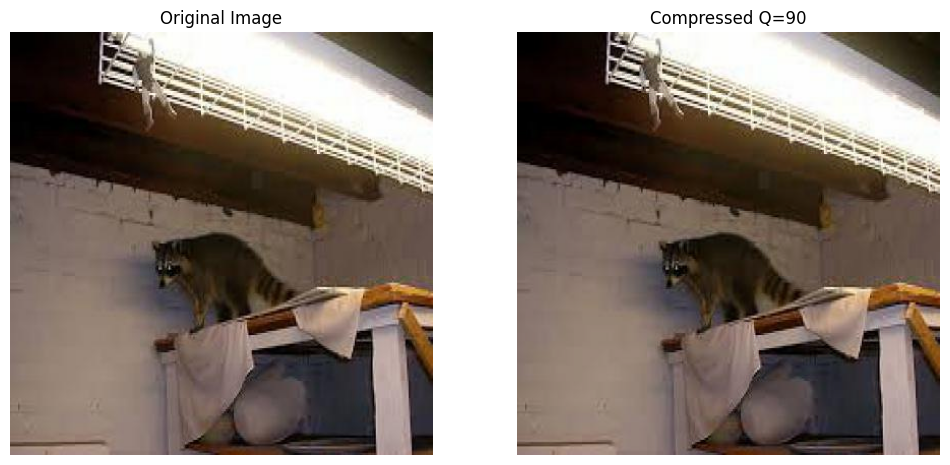

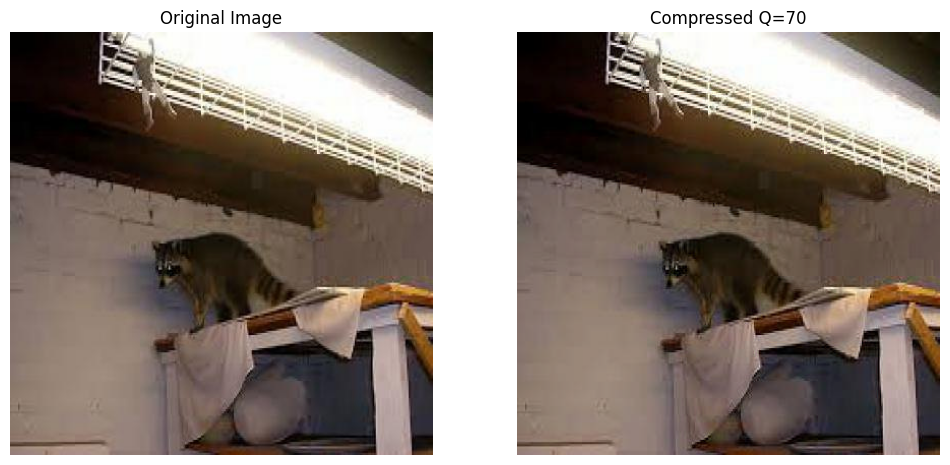

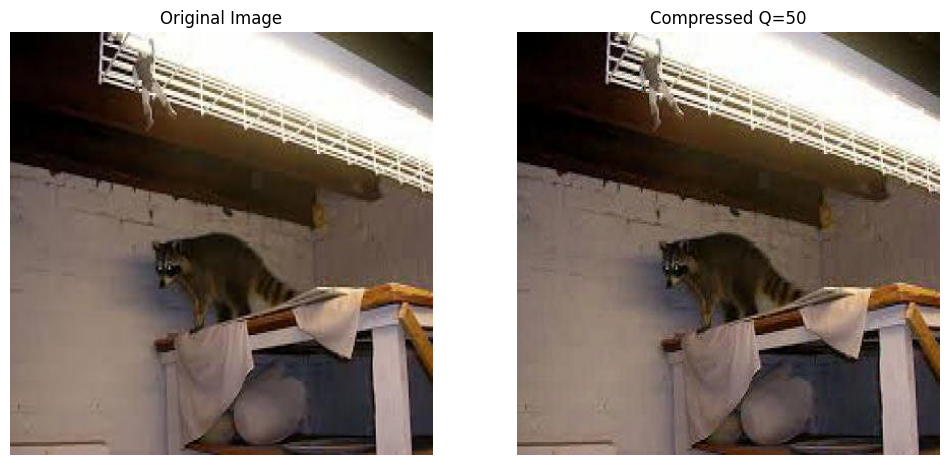

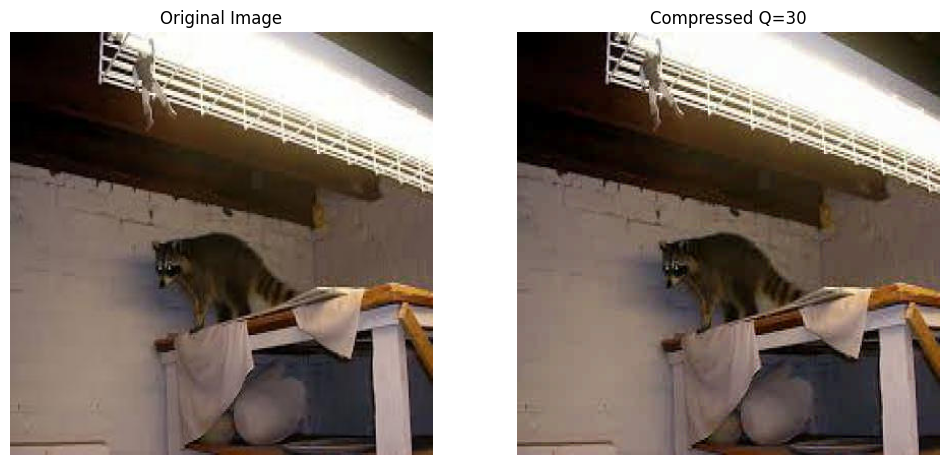

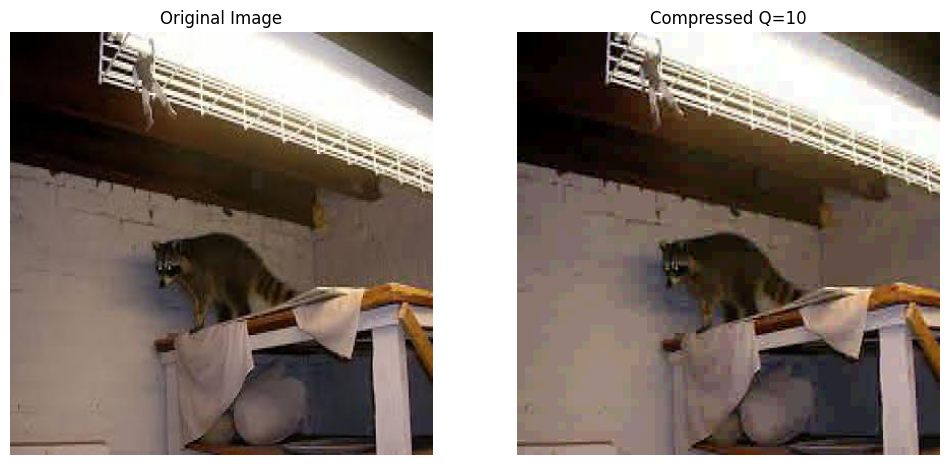

                                                  Image  Quality         CR  \
0     raccoon-128_jpg.rf.d69ad1a11a7823bd0e3818419b1...       90  18.586937   
1     raccoon-128_jpg.rf.d69ad1a11a7823bd0e3818419b1...       70  24.076659   
2     raccoon-128_jpg.rf.d69ad1a11a7823bd0e3818419b1...       50  29.603096   
3     raccoon-128_jpg.rf.d69ad1a11a7823bd0e3818419b1...       30  41.800545   
4     raccoon-128_jpg.rf.d69ad1a11a7823bd0e3818419b1...       10  80.631800   
...                                                 ...      ...        ...   
1955        raccoon-114_jpg.rf.RiU3t94Jeo5W0fd770Vt.jpg       90  19.323631   
1956        raccoon-114_jpg.rf.RiU3t94Jeo5W0fd770Vt.jpg       70  24.336095   
1957        raccoon-114_jpg.rf.RiU3t94Jeo5W0fd770Vt.jpg       50  29.463236   
1958        raccoon-114_jpg.rf.RiU3t94Jeo5W0fd770Vt.jpg       30  43.001066   
1959        raccoon-114_jpg.rf.RiU3t94Jeo5W0fd770Vt.jpg       10  86.591139   

           bpp       PSNR      SSIM  
0     1.29122

In [ ]:
quality_factors = [90,70,50,30,10]
results = []

# For report, display first image only
displayed = False

for img_path in image_files:
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    for Q in quality_factors:
        reconstructed_channels = []
        for c in range(3):
            blocks, quant, huff_code, bitstream, ph, pw = compress_channel(img[:,:,c], Q)
            rec = decompress_channel(blocks, quant, ph, pw, h, w)
            reconstructed_channels.append(rec)
        rec_img = np.stack(reconstructed_channels, axis=2).astype(np.uint8)

        # Metrics
        psnr_val = psnr(img, rec_img)
        ssim_val = ssim(img, rec_img, channel_axis=2)
        orig_size = img.size*8
        comp_size = len(bitstream)
        cr = orig_size / comp_size
        bpp = comp_size/(h*w)
        results.append([img_name, Q, cr, bpp, psnr_val, ssim_val])

        # Display only the first image for report
        if not displayed:
            plt.figure(figsize=(12,6))
            plt.subplot(1,2,1)
            plt.imshow(img)
            plt.title("Original Image")
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow(rec_img)
            plt.title(f"Compressed Q={Q}")
            plt.axis('off')
            plt.show()
    displayed = True

df = pd.DataFrame(results, columns=['Image','Quality','CR','bpp','PSNR','SSIM'])
print(df)